<a href="https://colab.research.google.com/github/foadsadr/House_prediction_tehran/blob/main/preprocessing_properties.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install basemap
!pip install osmnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 942.4/942.4 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 44.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 75.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 60.1 MB/s eta 0:00:00
  Attempting uninstall: pyproj
    Found existing installation: pyproj 3.7.1
    Uninstalling pyproj-3.7.1:
      Successfully uninstalled pyproj-3.7.1
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.10.0
    Uninstalling matplotlib-3.10.0:
      Successfully uninstalled matplotlib-3.10.0


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.6/99.6 kB 2.4 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from scipy.stats import zscore
import seaborn as sns
from datetime import datetime
from dateutil.relativedelta import relativedelta
import re
import requests
import xml.etree.ElementTree as ET

In [ ]:
# pd.set_option('display.float_format', '{:.0f}'.format)

In [ ]:
drive.mount('/content/drive')
subpath ='/content/drive/My Drive/price-prediction'
df = pd.read_csv(f'{subpath}/delta_data/2024_Tehran_House_Price.csv')
df_region = pd.read_csv(f'{subpath}/delta_data/regions_updated.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pre_sales = ['پیش', 'درحالساخت', 'اقساط', 'سرمایه', 'سهام', 'پروژه', 'معاوضه', 'تهاتر', 'وام']

In [ ]:
df.head(4)

,Category,PropertyTypes,Title,Address,Latitude,Longitude,Age,Price,Meter,Loan,Parking,Elevator,WareHouse,Rooms,Floor,validDate,City,Region
0,خرید-فروش,آپارتمان,NaN,توحیدها ...,0.000000,0.000000,0,2.850000e+11,140.0,True,1,1,1,3,5,2024-01-02 16:14:12.453,تهران منطقه 2,شهرک غرب
1,خرید-فروش,آپارتمان,خرید / آپارتمان,شیخ بهایی شمالی ...,35.765915,51.394894,0,2.900000e+11,114.0,False,1,1,1,3,4,2024-11-04 15:18:28.580,تهران منطقه 3,شیخ بهایی
2,خرید-فروش,آپارتمان,NaN,فاز 4 ...,0.000000,0.000000,10,7.500000e+11,300.0,False,0,1,1,4,2,2024-01-01 18:44:36.453,تهران منطقه 2,شهرک غرب
3,خرید-فروش,آپارتمان,NaN,صرافها ...,0.000000,0.000000,8,1.920000e+11,120.0,False,1,1,1,3,2,2024-01-01 18:45:21.210,تهران منطقه 2,سعادت آباد


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84099 entries, 0 to 84098
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Category       84099 non-null  object 
 1   PropertyTypes  84099 non-null  object 
 2   Title          81553 non-null  object 
 3   Address        84099 non-null  object 
 4   Latitude       84099 non-null  float64
 5   Longitude      84099 non-null  float64
 6   Age            84099 non-null  int64  
 7   Price          84099 non-null  float64
 8   Meter          84099 non-null  float64
 9   Loan           84099 non-null  bool   
 10  Parking        84099 non-null  int64  
 11  Elevator       84099 non-null  int64  
 12  WareHouse      84099 non-null  int64  
 13  Rooms          84099 non-null  int64  
 14  Floor          84099 non-null  int64  
 15  validDate      84099 non-null  object 
 16  City           84099 non-null  object 
 17  Region         84099 non-null  object 
dtypes: boo

In [ ]:
df_region.head(4)

,id,name,link,lat,long
0,1,دربند,region-1-darband,35.813517,51.429482
1,2,نیاوران,region-1-niavaran,35.816056,51.470947
2,3,جمشیدیه-جماران,region-1-jamshidiyeh-jamaran,35.813984,51.461417
3,4,زعفرانیه,region-1-zafaraniyeh,35.807681,51.416379


In [ ]:
df_region.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 479 entries, 0 to 478
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      479 non-null    int64  
 1   name    479 non-null    object 
 2   link    479 non-null    object 
 3   lat     479 non-null    float64
 4   long    479 non-null    float64
dtypes: float64(2), int64(1), object(2)
memory usage: 18.8+ KB


In [ ]:
df['Age'] = df['Age'].astype('int')
df['Price'] = (df['Price']/10).astype('int')
df['Meter'] = df['Meter'].astype('int')
df['Loan'] = df['Loan'].astype('int')
df['Parking'] = df['Parking'].astype('int')
df['Elevator'] = df['Elevator'].astype('int')
df['WareHouse'] = df['WareHouse'].astype('int')
df['Rooms'] = df['Rooms'].astype('int')
df['Floor'] = df['Floor'].astype('int')
df['validDate'] = pd.to_datetime(df['validDate'])

df['DaysSinceRegistration'] = (datetime.now() - df['validDate']).dt.days.astype('int')

In [ ]:
rows_to_delete = df[df['Region'].isin(df_region['name']) & ~df['City'].str.contains('تهران')]
df = df[~df.index.isin(rows_to_delete.index)]

rows_to_delete = df[~df['Region'].isin(df_region['name'])]
df = df[~df.index.isin(rows_to_delete.index)]

# if 0 --> region fixed
print(len(df[~df['Region'].isin(df_region['name'])]))

0


In [ ]:
# Delete Pre-sale
df['Title'] = df['Title'].fillna('')

df = df[~df['Title'].str.contains('پیش')]
df = df[~df['Title'].str.contains('پیش فروش')]
df = df[~df['Title'].str.contains('پیش خرید')]
df = df[~df['Title'].str.contains('پیش پرداخت')]
df = df[~df['Title'].str.contains('در حال ساخت')]
df = df[~df['Title'].str.contains('اقساط')]
df = df[~df['Title'].str.contains('سرمایه گذاری')]
df = df[~df['Title'].str.contains('سهام')]
df = df[~df['Title'].str.contains('پروژه')]
df = df[~df['Title'].str.contains('معاوضه')]
df = df[~df['Title'].str.contains('تهاتر')]
df = df[~df['Title'].str.contains('وام')]


df = df.drop(['Title'], axis=1)

df['per_meter'] = (df['Price']/df['Meter']).astype('int')
df = df.where(df['per_meter']>25000000).dropna()
df = df.where(df['per_meter']<800000000).dropna()

# Divar
rows_to_delete = df[df['City'].str.contains('22') & df['per_meter']<50000000]
df = df[~df.index.isin(rows_to_delete.index)]

In [ ]:
# Fake data
df = df.where(df['Meter']>30).dropna()

df['P'] = df['Price'].astype(str).str.split('.').str[0].str[-3:].astype(int)
df['Price'] = df['Price'].astype('int')
df = df.where(df['P']==0).dropna()
df = df.drop(['P'], axis=1)

df = df[df['Price']>1000000000]

In [ ]:
def fill_lat_lon(x):
  if x['Latitude']==0:
      x['Latitude'] = x['lat']
  if x['Longitude']==0:
      x['Longitude'] = x['long']
  return x

df = df.merge(df_region[['name', 'lat', 'long']], left_on='Region', right_on='name', how='left')
df = df.apply(fill_lat_lon, 1)
df = df.drop(columns=['name', 'lat', 'long'])

In [ ]:
average_price_by_region = df.groupby('Region')['per_meter'].mean().reset_index()
average_price_by_region = average_price_by_region.rename(columns={'per_meter': 'Average_per_meter'})

df_region = df_region.merge(
    average_price_by_region,
    left_on='name',
    right_on='Region',
    how='left'
)

df_region = df_region.drop(columns=['Region'])
df_region = df_region.dropna()
df_region['Average_per_meter'] = df_region['Average_per_meter'].astype('int')

In [ ]:
df['Price'] = df['Price'].astype('int')

In [ ]:
df

,Category,PropertyTypes,Address,Latitude,Longitude,Age,Price,Meter,Loan,Parking,Elevator,WareHouse,Rooms,Floor,validDate,City,Region,DaysSinceRegistration,per_meter
0,خرید-فروش,آپارتمان,توحیدها ...,35.759061,51.376042,0.0,28500000000,140.0,1.0,1.0,1.0,1.0,3.0,5.0,2024-01-02 16:14:12.453,تهران منطقه 2,شهرک غرب,421.0,203571428.0
1,خرید-فروش,آپارتمان,شیخ بهایی شمالی ...,35.765915,51.394894,0.0,29000000000,114.0,0.0,1.0,1.0,1.0,3.0,4.0,2024-11-04 15:18:28.580,تهران منطقه 3,شیخ بهایی,114.0,254385964.0
2,خرید-فروش,آپارتمان,فاز 4 ...,35.759061,51.376042,10.0,75000000000,300.0,0.0,0.0,1.0,1.0,4.0,2.0,2024-01-01 18:44:36.453,تهران منطقه 2,شهرک غرب,422.0,250000000.0
3,خرید-فروش,آپارتمان,صرافها ...,35.786096,51.378144,8.0,19200000000,120.0,0.0,1.0,1.0,1.0,3.0,2.0,2024-01-01 18:45:21.210,تهران منطقه 2,سعادت آباد,422.0,160000000.0
4,خرید-فروش,آپارتمان,سعادت آباد ...,35.786096,51.378144,20.0,18900000000,135.0,0.0,1.0,1.0,1.0,3.0,2.0,2024-01-01 18:44:07.657,تهران منطقه 2,سعادت آباد,422.0,140000000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71082,خرید-فروش,آپارتمان,مروارید بالاتراز میدان کاج ...,35.786096,51.378144,9.0,14000000000,105.0,0.0,1.0,1.0,1.0,2.0,1.0,2024-05-14 15:21:19.477,تهران منطقه 2,سعادت آباد,288.0,133333333.0
71083,خرید-فروش,آپارتمان,علامه جنوبی ...,35.786326,51.381104,15.0,17500000000,116.0,0.0,1.0,1.0,1.0,2.0,2.0,2024-07-11 11:04:49.640,تهران منطقه 2,سعادت آباد,230.0,150862068.0
71084,خرید-فروش,آپارتمان,اختیاریه ...,35.786346,51.461177,18.0,13000000000,77.0,0.0,1.0,1.0,1.0,2.0,3.0,2024-07-11 11:25:36.167,تهران منطقه 3,اختیاریه,230.0,168831168.0
71085,خرید-فروش,آپارتمان,خیابان گلستان ...,35.738556,51.339280,0.0,14100000000,83.0,0.0,1.0,1.0,1.0,2.0,2.0,2024-07-11 11:28:27.650,تهران منطقه 2,مرزداران,230.0,169879518.0


In [ ]:
df_region_new = df_region.dropna()
df_region_new['Average_per_meter'] = df_region_new['Average_per_meter'].astype('int')
df_region_new

,id,name,link,lat,long,Average_per_meter
0,1,دربند,region-1-darband,35.813517,51.429482,158416487
1,2,نیاوران,region-1-niavaran,35.816056,51.470947,208090447
2,3,جمشیدیه-جماران,region-1-jamshidiyeh-jamaran,35.813984,51.461417,191218418
3,4,زعفرانیه,region-1-zafaraniyeh,35.807681,51.416379,242170858
4,5,محمودیه,region-1-mahmoodiyeh,35.796416,51.412695,232580058
...,...,...,...,...,...,...
472,473,کاشانک,region-1-kashanak,35.815068,51.481515,150764541
473,474,دارآباد,region-1-darabad,35.818201,51.494127,137460143
474,475,فرمانیه,region-1-farmanieh,35.805258,51.454840,215038909
475,476,کامرانیه,region-1-kamranieh,35.802239,51.461555,218595975


In [ ]:
df_region[df_region['Average_per_meter'].isna()]

,id,name,link,lat,long,Average_per_meter


In [ ]:
# main_df[main_df['Region']=='گلاب دره']
df['Region'].nunique()

429

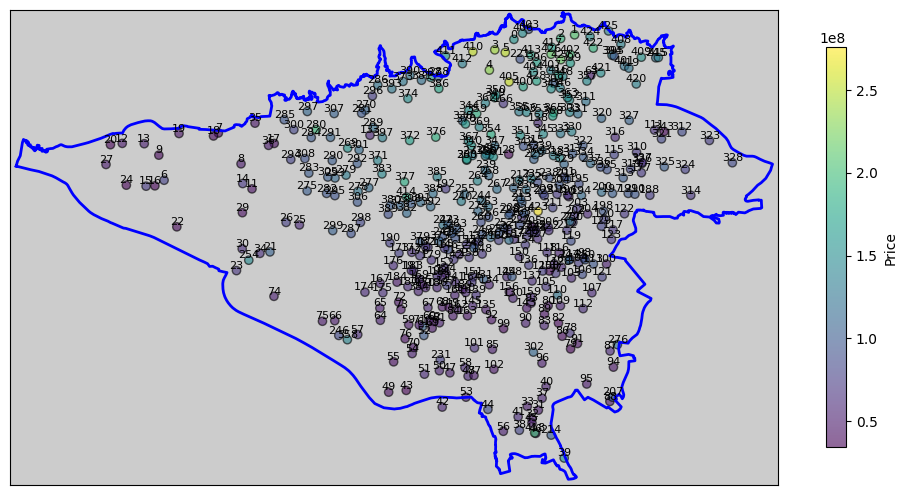

In [ ]:
from mpl_toolkits.basemap import Basemap
import osmnx as ox

def map(lo1, la1, lo2, la2):
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
    m = Basemap(llcrnrlon=lo1, llcrnrlat=la1,urcrnrlon=lo2,urcrnrlat=la2,
                rsphere=(6378137.00, 6356752.3142),
                resolution='l', projection='merc',
                lat_0=40., lon_0=-20., lat_ts=20.)

    m.drawcoastlines()
    m.fillcontinents()

    x, y = m(df_region['long'], df_region['lat'])
    scatter = plt.scatter(x, y, c=df_region['Average_per_meter'], cmap='viridis', alpha=0.6, edgecolor='k')

    cbar = plt.colorbar(scatter, ax=ax, orientation='vertical', label='Price', shrink=0.5)

    # Show Id!
    for i, txt in enumerate(df_region['id']):
        ax.annotate(txt, (x[i], y[i]), fontsize=8, ha='center', va='bottom')

    tehranshape = ox.geocode_to_gdf('Tehran, Iran')

    for geometry in tehranshape.geometry:
        if geometry.geom_type == 'Polygon':
            x, y = m(geometry.exterior.xy[0], geometry.exterior.xy[1])
            m.plot(x, y, color='blue', linewidth=2, ax=ax)
        elif geometry.geom_type == 'MultiPolygon':
            for polygon in geometry:
                x, y = m(polygon.exterior.xy[0], polygon.exterior.xy[1])
                m.plot(x, y, color='blue', linewidth=2, ax=ax)

    m.drawparallels(np.arange(20, 50, 10), labels=[1, 1, 0, 1])
    m.drawmeridians(np.arange(40, 80, 10), labels=[1, 1, 0, 1])
    ax.set_aspect('equal')
    plt.show()

df_region['id']= np.arange(len(df_region))
df_region = df_region.reset_index(drop=True)
map(51.085,35.565,51.61,35.83)

# map(51.0,35.5,51.8,35.9)
# map(51.25,35.6,51.55,35.8)

Fuad

In [ ]:
df_region.sort_values(by='Average_per_meter')

,id,name,link,lat,long,Average_per_meter
79,79,شهرک بروجردی,region-15-16-boroujerdi-town,35.640974,51.468227,34285714
16,16,پیکان شهر,region-21-22-peykanshahr,35.731917,51.184042,35000000
343,343,شهرک امید,region-4-omid-town,35.762184,51.532123,35000000
28,28,همت غرب,region-21-22-west-hemmat,35.749491,51.425912,35422740
43,43,شهید کاظمی,region-19-20-shahid-kazemi,35.617828,51.355847,36363636
...,...,...,...,...,...,...
3,3,زعفرانیه,region-1-zafaraniyeh,35.807681,51.416379,242170858
5,5,ولیعصر-باغ فردوس,region-1-valiasr-ferdows-garden,35.806215,51.423567,252427218
410,410,ولنجک,region-1-velenjak,35.806665,51.401393,253250261
405,405,الهیه,region-1-elahiyeh,35.789861,51.426202,256524456


In [ ]:
df.sort_values(by='Price')

,Category,PropertyTypes,Address,Latitude,Longitude,Age,Price,Meter,Loan,Parking,Elevator,WareHouse,Rooms,Floor,validDate,City,Region,DaysSinceRegistration,per_meter
13166,خرید-فروش,آپارتمان,دریاچه چیتگر... ...,35.716956,51.243865,0.0,1260000000,50.0,1.0,1.0,1.0,1.0,1.0,12.0,2024-01-10 12:25:55.770,تهران منطقه 21 و 22,چیتگر,413.0,25200000.0
9127,خرید-فروش,آپارتمان,دریاچه چیتگر ...,35.716956,51.243865,0.0,1282000000,50.0,1.0,1.0,1.0,1.0,1.0,12.0,2024-01-15 12:52:02.067,تهران منطقه 21 و 22,چیتگر,408.0,25640000.0
11802,خرید-فروش,آپارتمان,چیتگر ...,35.716956,51.243865,0.0,1282000000,50.0,1.0,1.0,1.0,1.0,1.0,8.0,2024-01-10 12:48:47.197,تهران منطقه 21 و 22,چیتگر,413.0,25640000.0
9918,خرید-فروش,آپارتمان,امیر کبیر ...,35.754480,51.261747,0.0,1285000000,50.0,1.0,1.0,1.0,1.0,1.0,10.0,2024-01-17 16:14:10.977,تهران منطقه 21 و 22,شهرک راه آهن,406.0,25700000.0
26799,خرید-فروش,آپارتمان,اردستانی ...,35.714492,51.183709,0.0,1300000000,50.0,1.0,1.0,1.0,1.0,1.0,0.0,2024-02-24 11:30:56.237,تهران منطقه 21 و 22,چیتگر,368.0,26000000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12078,خرید-فروش,آپارتمان,صرافها ...,35.786096,51.378144,0.0,650000000000,1100.0,0.0,1.0,1.0,1.0,6.0,15.0,2024-11-04 12:15:37.527,تهران منطقه 2,سعادت آباد,114.0,590909090.0
66017,خرید-فروش,آپارتمان,اندرزگو ...,35.725719,51.356081,0.0,670000000000,950.0,0.0,1.0,1.0,1.0,5.0,14.0,2024-02-09 09:59:54.893,تهران منطقه 1,اندرزگو,384.0,705263157.0
37432,خرید-فروش,آپارتمان,فرشته ...,35.717713,51.445969,0.0,675000000000,950.0,0.0,1.0,1.0,1.0,4.0,16.0,2024-08-15 15:33:06.713,تهران منطقه 1,فرشته,195.0,710526315.0
22402,خرید-فروش,آپارتمان,خیابان فرمانیه ...,35.805258,51.454840,2.0,680000000000,1200.0,0.0,1.0,1.0,1.0,6.0,10.0,2024-11-04 09:36:19.387,تهران منطقه 1,فرمانیه,115.0,566666666.0


In [ ]:
print("Count of data where UnitInFloor != 0:\t", len(df['UnitInFloor'][df['UnitInFloor']!=0]))
print("Count of data where TotalFloor != 0:\t", len(df['TotalFloor'][df['TotalFloor']!=0]))
print("Count of data where TotalArea != 0:\t", len(df['TotalArea'][df['TotalArea']!=0]))

KeyError: 'UnitInFloor'

In [ ]:
df = df.drop(['Category',	'PropertyTypes', 'Address'], axis=1)

In [ ]:
df = df.drop(['City',	'Region', 'validDate'], axis=1)


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 71061 entries, 0 to 71086
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Latitude               71061 non-null  float64
 1   Longitude              71061 non-null  float64
 2   Age                    71061 non-null  float64
 3   Price                  71061 non-null  int64  
 4   Meter                  71061 non-null  float64
 5   Loan                   71061 non-null  float64
 6   Parking                71061 non-null  float64
 7   Elevator               71061 non-null  float64
 8   WareHouse              71061 non-null  float64
 9   Rooms                  71061 non-null  float64
 10  Floor                  71061 non-null  float64
 11  DaysSinceRegistration  71061 non-null  float64
 12  per_meter              71061 non-null  float64
dtypes: float64(12), int64(1)
memory usage: 7.6 MB


In [ ]:
def openstreet(x):
    lat = x['latitude']
    long = x['longitude']
    url = f"https://nominatim.openstreetmap.org/reverse?lat={lat}&lon={long}&format=xml"
    headers = {
        "User-Agent": "MyApp/1.0 (myemail@example.com)"
    }
    response = requests.get(url, headers=headers)
    if response.status_code == 200:
        root = ET.fromstring(response.text)
        city = root.find(".//city")
        if city is not None and city.text == 'شهر تهران':
            suburb = root.find(".//suburb")
            if suburb is not None:
                x['Suburb'] = suburb.text
            else:
                print("suburb not found.")
        else:
            print("city not found.")
        return x

df['Suburb'] = np.full(len(df), np.nan).astype(object)

df[['latitude', 'longitude', 'Suburb']] = df[['latitude', 'longitude', 'Suburb']].apply(openstreet, axis=1)

city not found.


KeyboardInterrupt: 

In [ ]:
def extract_numbers(region):
    numbers = re.findall(r'\d+', region)
    if len(numbers)>1:
      return numbers[0]+'_'+numbers[1]
    elif len(numbers)==0:
      if region == 'پردیس':
        return '0'
      else:
        return '-'
    else:
      return numbers[0]

df['Area'] = df['City'].apply(extract_numbers)

count = df['Area'].apply(lambda x: '-'==x).sum()
print("Count of samples not in Tehran or Pardis:", count)

Count of samples not in Tehran or Pardis: 0


In [ ]:
df

,latitude,longitude,age,Price,Meter,Loan,Parking,Elevator,WareHouse,Rooms,Floor,RegisteredTime,City,Region,per_meter,lat,long,Area
0,35.732710,51.340620,0.0,2.600000e+11,143.0,False,1.0,1.0,1.0,3.0,3.0,2025-01-22 15:23:46.2523286,تهران منطقه 2,مرزداران,1.818182e+09,35.732710,51.340620,2
1,35.790305,51.444977,7.0,1.800000e+14,130.0,False,1.0,1.0,1.0,3.0,3.0,2025-01-02 12:09:21.6832131,تهران منطقه 1,قیطریه,1.384615e+12,35.790305,51.444977,1
2,35.775322,51.464249,10.0,1.800000e+11,125.0,False,1.0,1.0,1.0,2.0,1.0,2024-12-31 23:52:01.8696491,تهران منطقه 3,پاسداران,1.440000e+09,35.775322,51.464249,3
3,35.786346,51.461177,0.0,1.200000e+11,88.0,False,1.0,1.0,1.0,2.0,1.0,2024-12-31 23:52:07.9165052,تهران منطقه 3,اختیاریه,1.363636e+09,35.786346,51.461177,3
4,35.786346,51.461177,11.0,1.350000e+11,88.0,False,1.0,1.0,1.0,2.0,1.0,2024-12-31 23:20:00.7020948,تهران منطقه 3,اختیاریه,1.534091e+09,35.786346,51.461177,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7774,35.735145,51.435465,12.0,1.112500e+11,89.0,False,1.0,1.0,1.0,2.0,2.0,2024-11-05 13:16:00.3942690,تهران منطقه 7,سهروردی-شمالی,1.250000e+09,35.732539,51.439647,7
7775,35.726615,51.435898,10.0,1.070000e+11,94.0,False,1.0,1.0,1.0,2.0,5.0,2024-11-05 13:16:15.3336955,تهران منطقه 7,سهروردی-شمالی,1.138298e+09,35.732539,51.439647,7
7776,35.759061,51.376042,15.0,1.100000e+11,75.0,False,1.0,1.0,1.0,2.0,4.0,2024-11-05 13:12:14.4402879,تهران منطقه 2,شهرک غرب,1.466667e+09,35.759061,51.376042,2
7777,35.759061,51.376042,20.0,1.720000e+11,130.0,False,1.0,1.0,1.0,3.0,4.0,2024-11-05 13:04:03.2866613,تهران منطقه 2,شهرک غرب,1.323077e+09,35.759061,51.376042,2


In [ ]:
df['latitude'].isna().sum()

0

In [ ]:
df = df.where(df['Area']!='-').dropna()

In [ ]:
df['Area'].nunique()

18

In [ ]:
df['Area'].unique()

array(['2', '1', '3', '10', '9_10', '5', '21_22', '8', '6', '7', '4',
       '11_12', '13_14', '19_20', '15_16', '17_18', '9', '12'],
      dtype=object)

In [ ]:
df['Region'].nunique()

296

In [ ]:
df = df.drop(['Region',	'City'], axis=1)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7284 entries, 0 to 7778
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   latitude               7284 non-null   float64       
 1   longitude              7284 non-null   float64       
 2   age                    7284 non-null   int64         
 3   Price                  7284 non-null   int64         
 4   Meter                  7284 non-null   int64         
 5   Loan                   7284 non-null   int64         
 6   Parking                7284 non-null   int64         
 7   Elevator               7284 non-null   int64         
 8   WareHouse              7284 non-null   int64         
 9   Rooms                  7284 non-null   int64         
 10  Floor                  7284 non-null   int64         
 11  RegisteredTime         7284 non-null   datetime64[ns]
 12  per_meter              7284 non-null   float64       
 13  lat     

#**2 options:**
*   **extract lat/lon from Region**
*   **delete lat/lon**

In [ ]:
# df = df.drop(['latitude', 'longitude'], axis=1)

In [ ]:
df = df.drop(['RegisteredTime'], axis=1)

In [ ]:
df = df.drop(['lat', 'long'], axis=1)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7284 entries, 0 to 7778
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   latitude               7284 non-null   float64
 1   longitude              7284 non-null   float64
 2   age                    7284 non-null   int64  
 3   Price                  7284 non-null   int64  
 4   Meter                  7284 non-null   int64  
 5   Loan                   7284 non-null   int64  
 6   Parking                7284 non-null   int64  
 7   Elevator               7284 non-null   int64  
 8   WareHouse              7284 non-null   int64  
 9   Rooms                  7284 non-null   int64  
 10  Floor                  7284 non-null   int64  
 11  per_meter              7284 non-null   float64
 12  Area                   7284 non-null   object 
 13  DaysSinceRegistration  7284 non-null   int64  
dtypes: float64(3), int64(10), object(1)
memory usage: 1.1+ MB


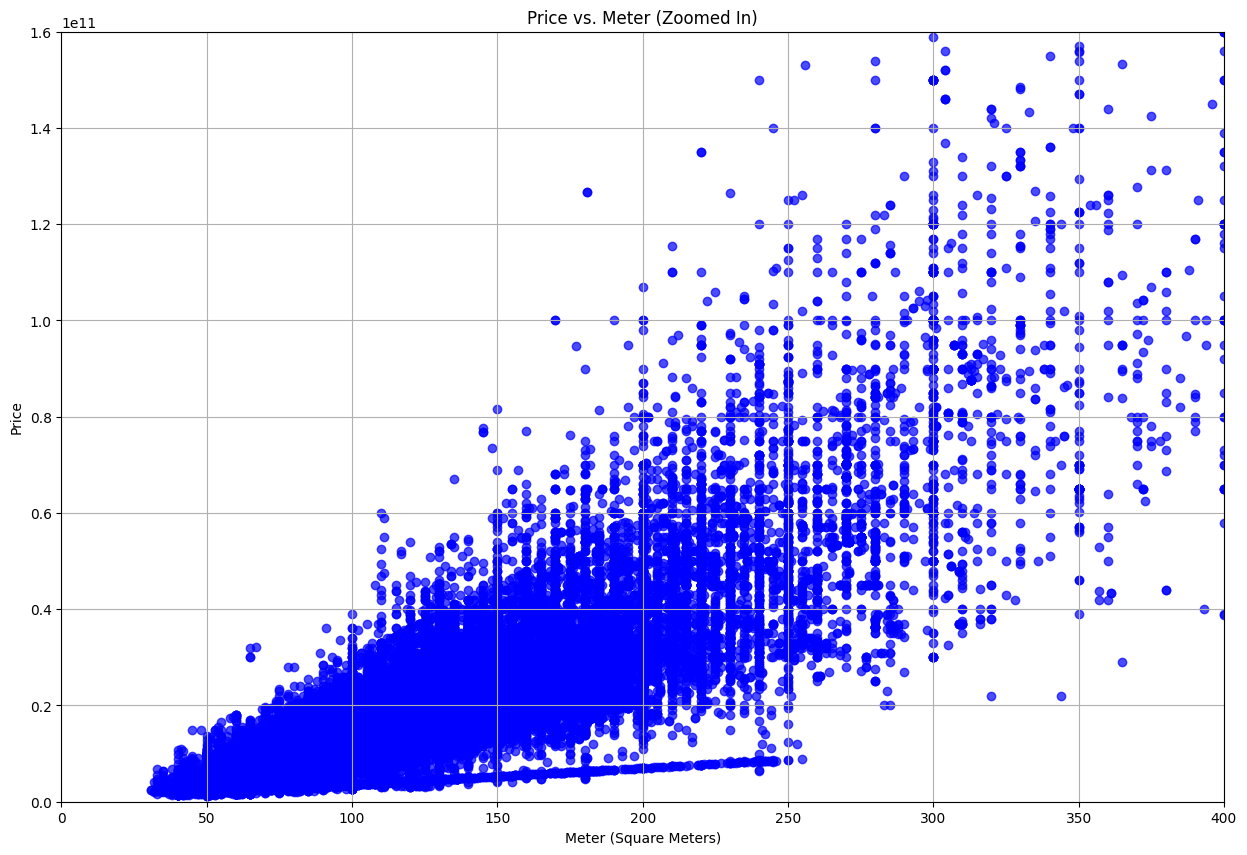

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))
plt.scatter(df['Meter'], df['Price'], alpha=0.7, color='blue')

plt.xlim(0, 400)
plt.ylim(0, 1.6e11)

plt.xlabel('Meter (Square Meters)')
plt.ylabel('Price')
plt.title('Price vs. Meter (Zoomed In)')

plt.grid(True)
plt.show()

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer

df_encoded = pd.get_dummies(df, columns=['Area'], drop_first=True, dtype=int)

df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7284 entries, 0 to 7778
Data columns (total 30 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   latitude               7284 non-null   float64
 1   longitude              7284 non-null   float64
 2   age                    7284 non-null   int64  
 3   Price                  7284 non-null   int64  
 4   Meter                  7284 non-null   int64  
 5   Loan                   7284 non-null   int64  
 6   Parking                7284 non-null   int64  
 7   Elevator               7284 non-null   int64  
 8   WareHouse              7284 non-null   int64  
 9   Rooms                  7284 non-null   int64  
 10  Floor                  7284 non-null   int64  
 11  per_meter              7284 non-null   float64
 12  DaysSinceRegistration  7284 non-null   int64  
 13  Area_10                7284 non-null   int64  
 14  Area_11_12             7284 non-null   int64  
 15  Area_12  

In [ ]:
df_encoded['Area_21_22'][df_encoded['Area_21_22']==1]

,Area_21_22
17,1
58,1
60,1
90,1
92,1
...,...
7747,1
7755,1
7760,1
7763,1


--------------------------------------------------------------------------------------------------------------------
#TRAIN & TEST

In [ ]:
def result(y_pred):
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.7, color='blue', label='Predictions')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='Perfect Prediction')
    plt.xlabel('Actual Prices')
    plt.ylabel('Predicted Prices')
    plt.title('Actual vs. Predicted Prices')
    plt.legend()
    plt.grid(True)
    plt.show()

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print("Mean Squared Error (MSE):", mse)
    print("R-squared (R2):", r2)

In [ ]:
upper_cap_95 = df_encoded['Price'].quantile(0.95)
upper_cap_99 = df_encoded['Price'].quantile(0.99)

df_encoded['Price_capped_95'] = df_encoded['Price'].clip(upper=upper_cap_95)
df_encoded['Price_avg'] = (df_encoded['Price'] + df_encoded['Price_capped_95']) / 2

df_encoded['Price_capped'] = df_encoded['Price_avg'].clip(upper=upper_cap_99)
df_encoded['Price_capped'] = df_encoded['Price_capped'].astype('int')
print(df_encoded[['Price','Price_capped', 'Meter', 'age', 'Rooms', 'Floor']][df_encoded['Price'] > upper_cap_99])

X = df_encoded.drop(['Price', 'Price_capped_95', 'Price_avg', 'Price_capped'], axis=1)
y = df_encoded['Price_capped']

continuous_features = ['age', 'Meter', 'DaysSinceRegistration', 'per_meter']
scaler = StandardScaler()
X[continuous_features] = scaler.fit_transform(X[continuous_features])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

                Price  Price_capped  Meter  age  Rooms  Floor
1     180000000000000  750000000000    130    7      3      3
61       850000000000  630000000000    350   15      3      5
78       890000000000  650000000000    275   10      3      7
80       880000000000  645000000000    360   20      4      6
273      770000000000  590000000000    250   20      3      1
...               ...           ...    ...  ...    ...    ...
7370    2250000000000  750000000000    430    2      5      7
7529    1250000000000  750000000000    425   20      4      9
7652    1220000000000  750000000000    283    0      3      8
7751     783000000000  596500000000    252    0      3     10
7762    1206000000000  750000000000    335   12      3     14

[70 rows x 6 columns]


In [ ]:
# Linear Regression

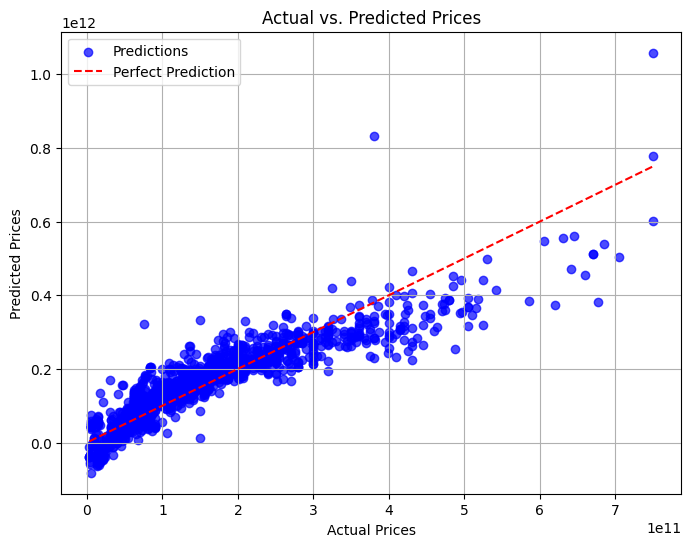

Mean Squared Error (MSE): 2.688847515557327e+21
R-squared (R2): 0.8190334110685872


In [ ]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

y_pred_lr = lr_model.predict(X_test)

result(y_pred_lr)

In [ ]:
# Polynomial Regression

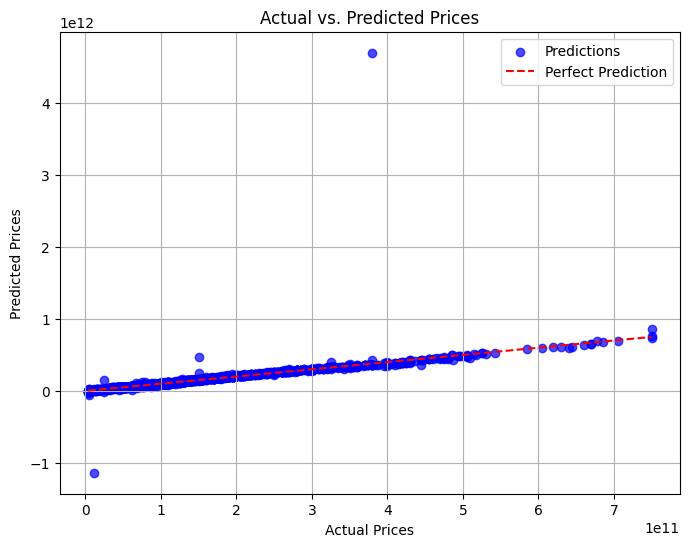

Mean Squared Error (MSE): 1.393506970304264e+22
R-squared (R2): 0.062132747918803743


In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

degree = 2
poly_model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
poly_model.fit(X_train, y_train)

y_pred_poly = poly_model.predict(X_test)

result(y_pred_poly)

In [ ]:
# Random Forest

Best Parameters: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 80}


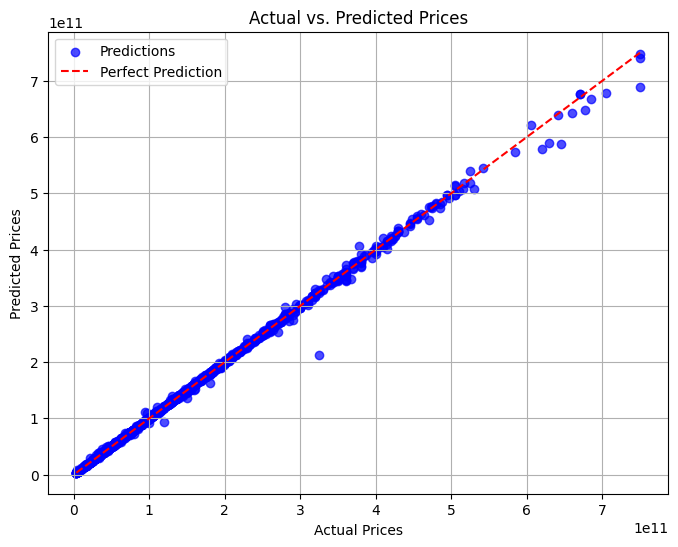

Mean Squared Error (MSE): 2.5627516510105248e+19
R-squared (R2): 0.9982751999811131


In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=50, max_depth=10, random_state=42)

param_grid = {
    'n_estimators': [80, 100, 150],
    'max_depth': [20, 30, 40, None],
    'min_samples_split': [5, 8, 10]
}

grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='r2')
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)


best_rf_model = grid_search.best_estimator_
y_pred_rf_best = best_rf_model.predict(X_test)

result(y_pred_rf_best)

In [ ]:
# XGBoost

In [ ]:
from cuml import XGBRegressor

xgb_model = XGBRegressor(tree_method='gpu_hist', gpu_id=0)

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

xgb_model =  XGBRegressor(tree_method='gpu_hist', gpu_id=0)

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best Parameters (XGBoost):", grid_search.best_params_)

best_xgb_model = grid_search.best_estimator_
y_pred_xgb_best = best_xgb_model.predict(X_test)

result(y_pred_xgb_best)

ImportError: cannot import name 'XGBRegressor' from 'cuml' (/usr/local/lib/python3.11/dist-packages/cuml/__init__.py)

In [ ]:
import psutil
def get_size(bytes, suffix="B"):
    factor = 1024
    for unit in ["", "K", "M", "G", "T", "P"]:
        if bytes < factor:
            return f"{bytes:.2f}{unit}{suffix}"
        bytes /= factor
print("="*40, "Memory Information", "="*40)
svmem = psutil.virtual_memory()
print(f"Total: {get_size(svmem.total)}") ; print(f"Available: {get_size(svmem.available)}")
print(f"Used: {get_size(svmem.used)}") ; print(f"Percentage: {svmem.percent}%")

======================================== Memory Information ========================================
Total: 12.67GB
Available: 10.64GB
Used: 1.72GB
Percentage: 16.1%


In [ ]:
degree = 2
coefficients = np.polyfit(X_train, y_train, degree)

poly_function = np.poly1d(coefficients)

X_fit = np.linspace(1, 5, 100)
y_fit = poly_function(X_fit)

plt.scatter(X, y, color='blue', label='Data')
plt.plot(X_fit, y_fit, color='red', label='Fitted Polynomial')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.show()

TypeError: expected 1D vector for x

In [ ]:
param_grid = {
    'n_estimators': [100, 150, 200, 250],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [8, 10, 12, 15]
}

grid_search = GridSearchCV(estimator=model5, param_grid=param_grid, cv=5, scoring='r2')
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)

best_model = grid_search.best_estimator_
y_pred_best = best_model5.predict(X_test)
r2_xgb_best = r2_score(y_test, y_pred_xgb_best)
mse_xgb_best = mean_squared_error(y_test, y_pred_xgb_best)

print("R-squared (Best XGBoost):", r2_xgb_best)
print("MSE (Best XGBoost):", mse_xgb_best)

Best Parameters: {'max_depth': None, 'min_samples_split': 10, 'n_estimators': 200}
R-squared (Best Model): 0.887628599106915


In [ ]:
upper_cap = df_encoded['Price'].quantile(0.95)
df_encoded['Price_capped'] = df_encoded['Price'].clip(upper=upper_cap)

X = df_encoded.drop(['Price', 'Price_capped'], axis=1)
y = df_encoded['Price_capped']

continuous_features = ['age', 'Meter', 'DaysSinceRegistration']
scaler = StandardScaler()
X[continuous_features] = scaler.fit_transform(X[continuous_features])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

xgb_model =  XGBRegressor(tree_method='gpu_hist', gpu_id=0)

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best Parameters (XGBoost):", grid_search.best_params_)

best_xgb_model = grid_search.best_estimator_
y_pred_xgb_best = best_xgb_model.predict(X_test)
r2_xgb_best = r2_score(y_test, y_pred_xgb_best)
mse_xgb_best = mean_squared_error(y_test, y_pred_xgb_best)

print("R-squared (Best XGBoost):", r2_xgb_best)
print("MSE (Best XGBoost):", mse_xgb_best)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:21:43] WARNING: /workspace/src/common/error_msg.cc:45: `gpu_id` is deprecated since2.0.0, use `device` instead. E.g. device=cpu/cuda/cuda:0
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:21:43] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Best Parameters (XGBoost): {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.9}
R-squared (Best XGBoost): 0.8928739112717459
MSE (Best XGBoost): 1.0905018527665649e+21


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:21:44] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:21:44] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


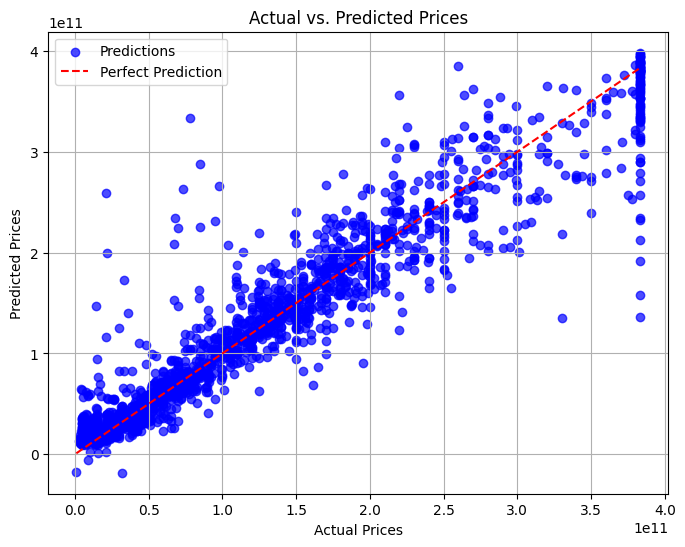

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_xgb_best, alpha=0.7, color='blue', label='Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='Perfect Prediction')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs. Predicted Prices')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
!nvidia-smi

Sat Feb 22 13:32:38 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   40C    P8             12W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/pip-install.py

fatal: destination path 'rapidsai-csp-utils' already exists and is not an empty directory.
Using Python 3.11.11 environment at: /usr
Resolved 2 packages in 117ms
Prepared 2 packages in 24ms
Installed 2 packages in 1ms
 + nvidia-ml-py==12.570.86
 + pynvml==12.0.0
Installing RAPIDS remaining 24.12.* libraries
Using Python 3.11.11 environment at: /usr
Resolved 154 packages in 1.25s
 Downloaded ucx-py-cu12
 Downloaded dask
 Downloaded cuspatial-cu12
 Downloaded libcuspatial-cu12
 Downloaded datashader
 Downloaded libucx-cu12
 Downloaded cucim-cu12
 Downloaded scikit-image
 Downloaded raft-dask-cu12
 Downloaded cuml-cu12
 Downloaded cugraph-cu12
 Downloaded cuvs-cu12
Prepared 30 packages in 39.58s
Uninstalled 3 packages in 43ms
Installed 30 packages in 123ms
 + cucim-cu12==24.12.0
 + cugraph-cu12==24.12.0
 + cuml-cu12==24.12.0
 + cuproj-cu12==24.12.0
 + cuspatial-cu12==24.12.0
 + cuvs-cu12==24.12.0
 + cuxfilter-cu12==24.12.0
 - dask==2024.10.0
 + dask==2024.11.2
 + dask-cuda==24.12.0
 + das

In [ ]:
import cuml
print(cuml.__version__)

24.12.00
